In [1]:
import numpy as np

from tqdm import tqdm
from matplotlib import pyplot as plt

import torch, numpy as np
import torch.nn.functional as F
import torch.nn as nn
import torch.utils.data as Data
import matplotlib.pyplot as plt


SEED = 4200
torch.manual_seed(SEED)
np.random.seed(SEED)

torch.set_default_dtype(torch.float64)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Matrix factorization through vanilla SCA

In [3]:
def MF_SCA(A, L, lambda_v = 0.1, lambda_w = 0.1, eta_v = 0.9, eta_w = 0.9, max_iter = 200):
    m = A.shape[0]
    n = A.shape[1]

    V = np.ones((m,L))
    W = np.ones((L,n))

    # Let's also keep the Frobenius distances between the matrix A and its reconstruction VW
    D = np.zeros(max_iter)

    for _ in tqdm(range(max_iter)):   

        # Local optimization step
        V_hat = A @ W.T @ np.linalg.inv(W @ W.T + lambda_v * np.eye(L))
        W_hat = np.linalg.inv(V.T @ V + lambda_w * np.eye(L)) @ V.T @ A   

        # Global smoothing step
        V = V + eta_v * (V_hat - V)
        W = W + eta_w * (W_hat - W)

        # Decreasing stepsize
        eta_v = eta_v * 0.99
        eta_w = eta_w * 0.99

        # Storing the reconstruction error
        D[_] = np.linalg.norm(A - V @ W, ord = 'fro')

    return (V,W), D

In [4]:
A = np.random.normal(size = (150,200))
A /= np.linalg.norm(A, axis = 0)

In [5]:
(V,W), D = MF_SCA(A,70)

100%|██████████| 200/200 [00:02<00:00, 72.68it/s]


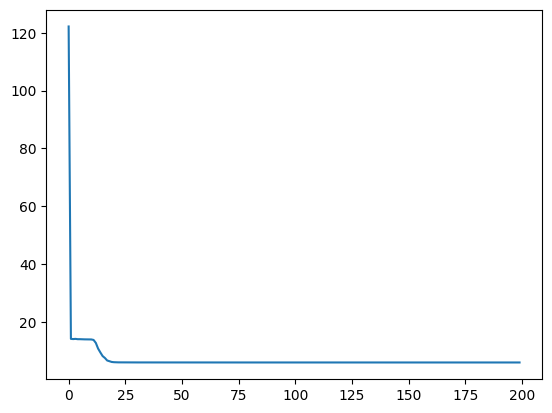

In [6]:
plt.plot(D)

### Matrix factorization through unrolled learnable optimization 

In [10]:
class SyntheticMatrices():
    def __init__(self, m, n, size = 1000, batch_size = 1):
        
        # Matrix shape
        self.m = m 
        self.n = n

        self.size = size    # Size of the dataset

        self.A = torch.zeros(self.size,self.m,self.n)

        self.batch_size = batch_size

        # Generating the dataset
        self.set_data()


    def set_matrix(self, i):
        
        # Generating random matrix
        A = torch.randn(self.m, self.n)
        A /= torch.linalg.norm(A, axis = 0)
        self.A[i,:,:] = A
        

    def set_data(self):
        for i in range(self.size):
            self.set_matrix(i)
    
    
    def set_loader(self):
        return Data.DataLoader(dataset = Data.TensorDataset(self.A),
                               batch_size = self.batch_size,
                               shuffle = True)

In [11]:
# Dimensions for the matrices
m_ = 150
n_ = 200

# Building a training set and a test set 
train_set = SyntheticMatrices(
    m = m_,
    n = n_,
    size = 300,
    ).set_loader()

test_set = SyntheticMatrices(
    m = m_,
    n = n_,
    size = 75
    ).set_loader()

In [9]:
A_ex = test_set.dataset.__getitem__(0)[0]
A_ex

tensor([[ 1.0181e-01,  4.0673e-02,  9.6254e-02,  ...,  7.0328e-02,
         -6.3023e-02, -1.3664e-01],
        [ 7.2294e-02,  1.1580e-01, -8.5633e-02,  ..., -4.6978e-02,
         -3.1272e-02, -4.3983e-02],
        [-1.3297e-02, -2.8222e-02, -1.4585e-01,  ..., -7.6704e-02,
          1.0240e-02, -8.7173e-02],
        ...,
        [ 5.9802e-02,  8.9697e-02, -4.8075e-02,  ...,  1.2227e-01,
          8.0335e-02,  8.7796e-02],
        [-4.5872e-02, -1.3755e-02,  9.8003e-03,  ..., -6.2105e-02,
         -4.0016e-05, -6.4237e-02],
        [-1.3827e-01,  1.0906e-01,  2.4216e-03,  ...,  4.9032e-02,
          9.0870e-02, -3.8123e-02]])

In [12]:
(V,W), D = MF_SCA(A_ex.detach().numpy(), 100)

100%|██████████| 200/200 [00:01<00:00, 117.75it/s]


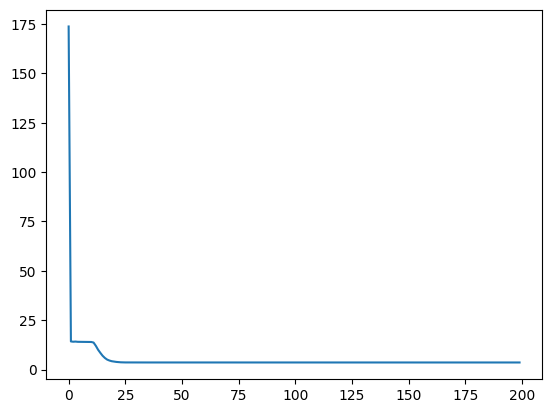

In [13]:
plt.plot(D)

In [60]:
class MFSCA_LAYER(nn.Module):
    def __init__(self, M, N, L, lambda_v = 0.1, lambda_w = 0.1, eta_v = 0.9, eta_w = 0.9):
        super().__init__()

        # Matrix shape and latent space dimension
        self.M = M
        self.N = N
        self.L = L

        # Initialization of the learnable parameters
        self.lambda_v = nn.Parameter(torch.ones(1)*lambda_v, requires_grad = True)
        self.lambda_w = nn.Parameter(torch.ones(1)*lambda_w, requires_grad = True)
        self.eta_v = nn.Parameter(torch.ones(1)*eta_v, requires_grad = True)
        self.eta_w = nn.Parameter(torch.ones(1)*eta_w, requires_grad = True)

    
    def forward(self, A, V, W):
        '''
        V_hat = A @ W.T @ torch.linalg.inv(W @ W.T + self.lambda_v * torch.eye(self.L))
        W_hat = torch.linalg.inv(V.T @ V + self.lambda_w * torch.eye(self.L)) @ V.T @ A
        '''
        # Block optimization
        
        V_hat = torch.bmm(torch.bmm(A, W.transpose(1, 2)),torch.inverse(torch.bmm(W, W.transpose(1,2)) + self.lambda_v * torch.eye(self.L)))
        W_hat = torch.bmm(torch.bmm(torch.inverse(torch.bmm(V.transpose(1,2),V) + self.lambda_w * torch.eye(self.L)),V.transpose(1,2)), A)

        # Convex smoothing
        V = V + self.eta_v * (V_hat - V)
        W = W + self.eta_w * (W_hat - W)

        
        # Nonlinearity
        '''
        V = F.relu(V)
        W = F.relu(W)
        '''
        
        
        return V, W

In [61]:
class DUMAFAC(nn.Module):
    def __init__(self, M, N, L, T = 20, lambda_v = 0.1, lambda_w = 0.1, eta_v = 0.9, eta_w = 0.9, batch_size = 1):
        super(DUMAFAC, self).__init__()
        self.batch_size = batch_size

        # Shapes and dimensions
        self.M = M
        self.N = N
        self.L = L

        # Number of iterations <-> number of layers
        self.T = T

        # Initialization of the learnable parameters
        self.lambda_v = torch.ones(T)*lambda_v
        self.lambda_w = torch.ones(T)*lambda_w
        self.eta_v = torch.ones(T)*eta_v
        self.eta_w = torch.ones(T)*eta_w
            
        # Defining the layers
        self.SCA_layers = nn.ModuleList(
            [
                MFSCA_LAYER(
                    self.M,
                    self.N, 
                    self.L,
                    self.lambda_v[i], 
                    self.lambda_w[i], 
                    self.eta_v[i],
                    self.eta_w[i]
                    ) 
                for i in range(self.T)
            ]
        )

    def forward(self,A):
        V = torch.ones((self.batch_size, self.M, self.L))
        W = torch.ones((self.batch_size, self.L, self.N))
        for i in range(self.T):
            V,W = self.SCA_layers[i].forward(A, V, W)

        return V,W

In [62]:
model = DUMAFAC(150,200,50, T = 30)

In [63]:
def trainer(model, train_loader, valid_loader, num_epochs=5):

    # Optimizer declaration
    optimizer = torch.optim.SGD(
        model.parameters(),
        lr=5e-03,
        momentum=0.9,
        weight_decay=0,
    )

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

    # Storing the loss
    loss_train = np.zeros((num_epochs,))
    loss_test = np.zeros((num_epochs,))

    for epoch in range(num_epochs):
        # Do the training and compute the loss
        model.train()
        train_loss = 0
        for _, (A) in enumerate(train_loader):
            V,W = model(A[0])
            loss = F.mse_loss(torch.bmm(V,W), A[0], reduction="sum")
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            for p in model.parameters():
                
                p.data = torch.clamp(p.data, 10e-4, 10e4)
                
                
            model.zero_grad()
            train_loss += loss.data.item()

        # Aggregate training loss
        loss_train[epoch] = train_loss / len(train_loader.dataset)
        scheduler.step()

        # Validation loss
        model.eval()
        test_loss = 0
        for _, (A) in enumerate(valid_loader):
            V,W = model(A[0])
            test_loss += F.mse_loss(V @ W, A[0], reduction="sum")
        loss_test[epoch] = test_loss / len(valid_loader.dataset)

        # Visualize some results during the training procedure
        if epoch % 10 == 0:
            print("Epoch %d, Train loss %.8f, Validation loss %.8f" % (epoch, loss_train[epoch], loss_test[epoch]))

    return loss_test

In [64]:
for i in range(model.T):
    print(model.SCA_layers[i].lambda_v)

Parameter containing:
tensor([0.1000], requires_grad=True)
Parameter containing:
tensor([0.1000], requires_grad=True)
Parameter containing:
tensor([0.1000], requires_grad=True)
Parameter containing:
tensor([0.1000], requires_grad=True)
Parameter containing:
tensor([0.1000], requires_grad=True)
Parameter containing:
tensor([0.1000], requires_grad=True)
Parameter containing:
tensor([0.1000], requires_grad=True)
Parameter containing:
tensor([0.1000], requires_grad=True)
Parameter containing:
tensor([0.1000], requires_grad=True)
Parameter containing:
tensor([0.1000], requires_grad=True)
Parameter containing:
tensor([0.1000], requires_grad=True)
Parameter containing:
tensor([0.1000], requires_grad=True)
Parameter containing:
tensor([0.1000], requires_grad=True)
Parameter containing:
tensor([0.1000], requires_grad=True)
Parameter containing:
tensor([0.1000], requires_grad=True)
Parameter containing:
tensor([0.1000], requires_grad=True)
Parameter containing:
tensor([0.1000], requires_grad=Tru

In [67]:
for p in model.parameters():
    print(p.data)

tensor([nan])
tensor([nan])
tensor([nan])
tensor([nan])
tensor([nan])
tensor([nan])
tensor([nan])
tensor([nan])
tensor([nan])
tensor([nan])
tensor([nan])
tensor([nan])
tensor([nan])
tensor([nan])
tensor([nan])
tensor([nan])
tensor([nan])
tensor([nan])
tensor([nan])
tensor([nan])
tensor([nan])
tensor([nan])
tensor([nan])
tensor([nan])
tensor([nan])
tensor([nan])
tensor([nan])
tensor([nan])
tensor([nan])
tensor([nan])
tensor([nan])
tensor([nan])
tensor([nan])
tensor([nan])
tensor([nan])
tensor([nan])
tensor([nan])
tensor([nan])
tensor([nan])
tensor([nan])
tensor([nan])
tensor([nan])
tensor([nan])
tensor([nan])
tensor([nan])
tensor([nan])
tensor([nan])
tensor([nan])
tensor([nan])
tensor([nan])
tensor([nan])
tensor([nan])
tensor([nan])
tensor([nan])
tensor([nan])
tensor([nan])
tensor([nan])
tensor([nan])
tensor([nan])
tensor([nan])
tensor([nan])
tensor([nan])
tensor([nan])
tensor([nan])
tensor([nan])
tensor([nan])
tensor([nan])
tensor([nan])
tensor([nan])
tensor([nan])
tensor([nan])
tensor

In [ ]:
trainer(model, train_set, test_set)

# To run on GPU

In [6]:
class MFSCA_LAYER(nn.Module):
    def __init__(self, M, N, L, lambda_v=0.1, lambda_w=0.1, eta_v=0.9, eta_w=0.9):
        super().__init__()

        # Matrix shape and latent space dimension
        self.M = M
        self.N = N
        self.L = L

        # Initialization of the learnable parameters
        self.lambda_v = nn.Parameter(torch.ones(1) * lambda_v, requires_grad=True)
        self.lambda_w = nn.Parameter(torch.ones(1) * lambda_w, requires_grad=True)
        self.eta_v = nn.Parameter(torch.ones(1) * eta_v, requires_grad=True)
        self.eta_w = nn.Parameter(torch.ones(1) * eta_w, requires_grad=True)

    def forward(self, A, V, W):
        '''
        V_hat = A @ W.T @ torch.linalg.inv(W @ W.T + self.lambda_v * torch.eye(self.L))
        W_hat = torch.linalg.inv(V.T @ V + self.lambda_w * torch.eye(self.L)) @ V.T @ A
        '''
        # Move tensors to the same device
        device = A.device

        # Block optimization
        V_hat = torch.bmm(torch.bmm(A, W.transpose(1, 2)), torch.inverse(torch.bmm(W, W.transpose(1, 2)) + self.lambda_v * torch.eye(self.L).to(device)))
        W_hat = torch.bmm(torch.bmm(torch.inverse(torch.bmm(V.transpose(1, 2), V) + self.lambda_w * torch.eye(self.L).to(device)), V.transpose(1, 2)), A)

        # Convex smoothing
        V = V + self.eta_v * (V_hat - V)
        W = W + self.eta_w * (W_hat - W)

        return V, W

class DUMAFAC(nn.Module):
    def __init__(self, M, N, L, T=20, lambda_v=0.1, lambda_w=0.1, eta_v=0.9, eta_w=0.9, batch_size=25):
        super(DUMAFAC, self).__init__()
        self.batch_size = batch_size

        # Shapes and dimensions
        self.M = M
        self.N = N
        self.L = L

        # Number of iterations <-> number of layers
        self.T = T

        # Initialization of the learnable parameters
        self.lambda_v = nn.Parameter(torch.ones(T) * lambda_v, requires_grad=True)
        self.lambda_w = nn.Parameter(torch.ones(T) * lambda_w, requires_grad=True)
        self.eta_v = nn.Parameter(torch.ones(T) * eta_v, requires_grad=True)
        self.eta_w = nn.Parameter(torch.ones(T) * eta_w, requires_grad=True)

        # Defining the layers
        self.SCA_layers = nn.ModuleList(
            [
                MFSCA_LAYER(
                    self.M,
                    self.N,
                    self.L,
                    lambda_v=self.lambda_v[i],
                    lambda_w=self.lambda_w[i],
                    eta_v=self.eta_v[i],
                    eta_w=self.eta_w[i]
                )
                for i in range(self.T)
            ]
        )

    def forward(self, A):
        device = A.device
        V = torch.ones((self.batch_size, self.M, self.L), device=device)
        W = torch.ones((self.batch_size, self.L, self.N), device=device)
        for i in range(self.T):
            V, W = self.SCA_layers[i].forward(A.to(device), V, W)

        return V, W


In [7]:
def trainer(model, train_loader, valid_loader, num_epochs=50):

    # Optimizer declaration
    optimizer = torch.optim.SGD(
        model.parameters(),
        lr=5e-05,
        momentum=0.9,
        weight_decay=0,
    )

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

    # Storing the loss
    loss_train = np.zeros((num_epochs,))
    loss_test = np.zeros((num_epochs,))

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(num_epochs):
        # Do the training and compute the loss
        model.train()
        train_loss = 0
        for _, (A) in enumerate(train_loader):
            A_ = A[0]
            A_ = A_.to(device)  # Move input data to GPU
            V, W = model(A_)
            loss = F.mse_loss(torch.bmm(V, W), A_, reduction="sum")
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
                
            train_loss += loss.item()

        # Aggregate training loss
        loss_train[epoch] = train_loss / len(train_loader.dataset)
        scheduler.step()

        # Validation loss
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for _, (A) in enumerate(valid_loader):
                A = A.to(device)  # Move input data to GPU
                V, W = model(A)
                test_loss += F.mse_loss(torch.bmm(V, W), A, reduction="sum")
            loss_test[epoch] = test_loss / len(valid_loader.dataset)

        # Visualize some results during the training procedure
        if epoch % 10 == 0:
            print("Epoch %d, Train loss %.8f, Validation loss %.8f" % (epoch, loss_train[epoch], loss_test[epoch]))

    return loss_test


In [8]:
model = DUMAFAC(M = 150, N = 200, L = 400).to(device)

In [ ]:
trainer(model, train_set, test_set)